## Wavenet example
This notebook is a simple demo of how to train wavenet. We use minimal data and loop over this data for just a few epochs. I recommend starting here to check you can properly load the data before moving onto training full ensembles. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

from torch.nn import MSELoss, Module
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('../src/')
from Wavenet import Wavenet
from GravityWavesDataset import GravityWavesDataset
from utils import count_parameters

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Set up data

Set up necessary directories and files. You will need to define `data_dir` as the location of your data. We are using minimal data for this example, with only daily data and with only 90 timesteps (Jan, Feb, Mar). We will need to increase this, but for demonstration purposes, this notebook should run without memory errors. 

In [3]:
# Set up directories and files - you will need to edit this to point to the location of your data 
data_dir = "/scratch/users/lauraman/WaveNetPyTorch/mima_runs/train_wavenet/"
filename = "atmos_daily_43.nc"

# What component of gravity wave drag? This can be "zonal" or "meridional".
component = "zonal"

# Use standard scaler transform to normalize to zero mean, unit variance.
transform = "standard"
means_filename = "atmos_all_43_mean.nc"
sd_filename = "atmos_all_43_std.nc"
transform_dict = {"filename_mean":means_filename, 
                      "filename_sd":sd_filename}

print("Loading datasets into memory.")
gw_dataset = GravityWavesDataset(data_dir, filename, 
                                 component = component,
                                 transform = transform,
                                 transform_dict = transform_dict,
                                 subset_time = (0, 90))

Loading datasets into memory.
Setting up dataset from single file: atmos_daily_43.nc
Done opening single file
Dataset has ntime=90. Getting variables.
Load into memory
Done. All variables as numpy arrays
Setting up transforms
Standard scaling


/home/users/lauraman/WaveNetPyTorch/examples/../src/GravityWavesDataset.py:285: RuntimeWarning: invalid value encountered in divide
  u = (u - u_mean) / u_sd


Dataset will return transformed variables (standard scaler)
Done. Dataset ready.


In [4]:
# We will also set up a validation dataset. 
print("Loading datasets into memory.")
valid_filename = "atmos_daily_44.nc"
valid_dataset = GravityWavesDataset(data_dir, valid_filename, 
                                    component = component,
                                    transform = transform,
                                    transform_dict = transform_dict,
                                    subset_time = (0, 90))

Loading datasets into memory.
Setting up dataset from single file: atmos_daily_44.nc
Done opening single file
Dataset has ntime=90. Getting variables.
Load into memory
Done. All variables as numpy arrays
Setting up transforms
Standard scaling
Dataset will return transformed variables (standard scaler)
Done. Dataset ready.


## What does this data look like? 
Let's look at the first timestep.

In [5]:
data_init = gw_dataset[0]
X = data_init["X"]
Y = data_init["Y"]
print(X.shape, Y.shape)

torch.Size([1, 82]) torch.Size([1, 40])


## Set up a dataloader 
We will train the model with a loop. First, setup the data loader. We can experiment with batch size. I am choosing to fix the validation batch size at 64, equal to the number of latitudes, and `shuffle=False` in the validation data loader, because the inverse scaling becomes simpler as we will see later.

In [6]:
# Set batch size 
batch_size = 64
n_samples = len(gw_dataset)
n_batches = n_samples//batch_size

# Set up dataloaders
train_dataloader = DataLoader(gw_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=64,
                              shuffle=False, num_workers=0, pin_memory=True)

## Define Wavenet model
Define the model and sanity check the size of the model

In [7]:
## New instance of model saved in src/Wavenet.py
my_model = Wavenet(n_in=82, n_out=40)

In [8]:
## Check if the sizes of our arrays are correct by predicting random point
batch = next(iter(train_dataloader))
X, Y = batch["X"].squeeze(), batch["Y"].squeeze()
X, Y = X.to(device), Y.to(device)
Y_pred = my_model(X).squeeze()
print(Y.shape, Y_pred.shape)

torch.Size([64, 40]) torch.Size([64, 40])


These should both give you `(batch_size, 40)`. If it all looks good, we are proceed to the training loop.

## Train model
Start the training loop

In [9]:
my_model = my_model.to(device)
my_model.train()

Wavenet(
  (shared): Sequential(
    (0): Linear(in_features=82, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (branches): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=32, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=32, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_feature

In [10]:
# Settings: you may want to experiment with these! 
n_epoch = 2
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-3)
loss_func = MSELoss()

In [11]:
# Save losses
losses = []
training_losses = []
validation_losses = []

In [12]:
print(f"Running {n_batches} batchs for batch size of {batch_size} \
for dataset size {n_samples}")


Running 11520 batchs for batch size of 64 for dataset size 737280


In [13]:
for ep in range(0, n_epoch):
    ## Training
    i = 0
    training_loss = 0
    my_model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X, Y = batch["X"].squeeze(), batch["Y"].squeeze()
        X, Y = X.to(device), Y.to(device)
        Y_pred = my_model(X).squeeze()
        err = loss_func(Y_pred, Y)
        err.backward()
        optimizer.step()
        losses.append(err.item())
        training_loss += err.item()
        if i % 1000 == 0:
            print(f"iteration: {i}, Loss:{err.item()}")
        i+=1

    training_loss = training_loss / i
    training_losses.append(training_loss)
    
    ## Validation 
    i = 0
    valid_loss = 0
    my_model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            X, Y = batch["X"].squeeze(), batch["Y"].squeeze()
            X, Y = X.to(device), Y.to(device)
            Y_pred = my_model(X).squeeze()
            err = loss_func(Y_pred, Y)
            valid_loss += err.item()
            i+=1

    valid_loss = valid_loss / i
    validation_losses.append(valid_loss)

    print(f"Epoch: {ep}, loss:{losses[-1]}, \
          total training loss: {training_loss} \
          total validation loss: {valid_loss}")

iteration: 0, Loss:1.4628220796585083
iteration: 1000, Loss:0.3353878855705261
iteration: 2000, Loss:0.19477388262748718
iteration: 3000, Loss:0.2140474021434784
iteration: 4000, Loss:0.18284641206264496
iteration: 5000, Loss:0.2111949473619461
iteration: 6000, Loss:0.23881688714027405
iteration: 7000, Loss:0.19464915990829468
iteration: 8000, Loss:0.14444950222969055
iteration: 9000, Loss:0.16161760687828064
iteration: 10000, Loss:0.2002657651901245
iteration: 11000, Loss:0.16907650232315063
Epoch: 0, loss:0.18568643927574158,           total training loss: 0.20680615712448747           total validation loss: 0.38635130832262804
iteration: 0, Loss:0.16075606644153595
iteration: 1000, Loss:0.15784823894500732
iteration: 2000, Loss:0.17212547361850739
iteration: 3000, Loss:0.17287404835224152
iteration: 4000, Loss:0.15797576308250427
iteration: 5000, Loss:0.12283257395029068
iteration: 6000, Loss:0.14089074730873108
iteration: 7000, Loss:0.16896125674247742
iteration: 8000, Loss:0.14859

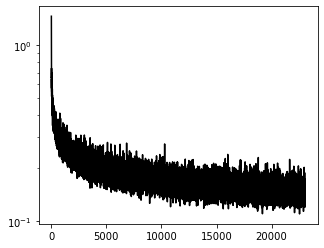

In [14]:
plt.figure(figsize=(5, 4))
plt.semilogy(losses, color='black')

After running several epochs, we can start comparing the training and validation losses. We expect the training loss to be lower than the validation loss.

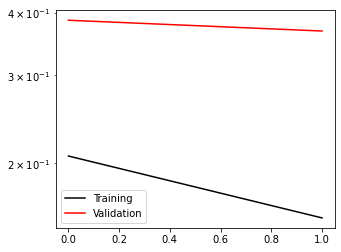

In [15]:
# After running several epochs, we can start comparing the training and validation losses
plt.figure(figsize=(5, 4))
plt.semilogy(training_losses, color="black", label="Training")
plt.semilogy(validation_losses, color="red", label="Validation")
plt.legend()

## Test performance
After one loop through the training dataset, let's check performance on the validation dataset

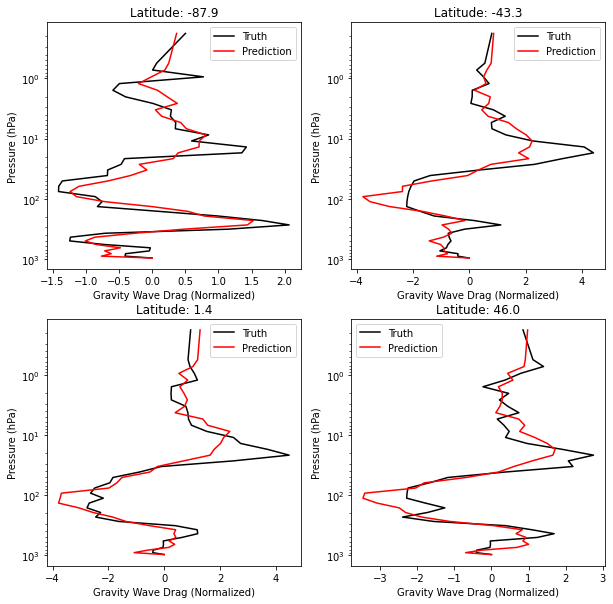

In [16]:
## Predict random point
batch = next(iter(valid_dataloader))
X, Y = batch["X"].squeeze().to(device), batch["Y"].squeeze()
# extract X and reshape to (1, 82), then convert to torch for model
Y_pred = my_model(X).to('cpu').squeeze()

fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()
# Plot a few samples for different latitudes
for i, j in enumerate(range(0, 64, 16)):
    plt.sca(ax[i])
    plt.semilogy(Y.detach()[j,:], 
                 gw_dataset.pfull, 
                 color="black", label="Truth")
    plt.semilogy(Y_pred.detach()[j,:],
                 gw_dataset.pfull, 
                 color="red", label="Prediction")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"Latitude: {gw_dataset.lat[j]:.1f}")
    plt.xlabel("Gravity Wave Drag (Normalized)")
    plt.ylabel("Pressure (hPa)")

It looks like the prediction is okay and matches the truth, but these profiles look strange and fluctuate a lot between model levels! Recall they are normalized to standard scaling with zero mean, unit variance. We would expect to see gravity wave drag to increase in magnitude with height. Let's check how they look when we apply the inverse scaling.

In [17]:
# First, need to extract gwfu_mean and gwfu_sd from our dataset 
# These are means over time and longitude so should be stored with shape
# time [1], pfull [40], lat [64], lon [1]) 
gwfu_mean = gw_dataset.gwfu_mean
gwfu_sd = gw_dataset.gwfu_sd
print(gwfu_mean.shape, gwfu_sd.shape)

(1, 40, 64, 1) (1, 40, 64, 1)


In [18]:
# We need to squeeze out time and lon and then transpose to (lat [64], pfull [40])
gwfu_mean = gw_dataset.gwfu_mean.squeeze().T
gwfu_sd = gw_dataset.gwfu_sd.squeeze().T
print(gwfu_mean.shape, gwfu_sd.shape)

(64, 40) (64, 40)


If the validation batch size is set to 64 and `shuffle=False` in the dataloader, each batch should be ordered correctly in latitude. This is convenient for our inverse scaling.

In [19]:
print(Y_pred.shape)

torch.Size([64, 40])


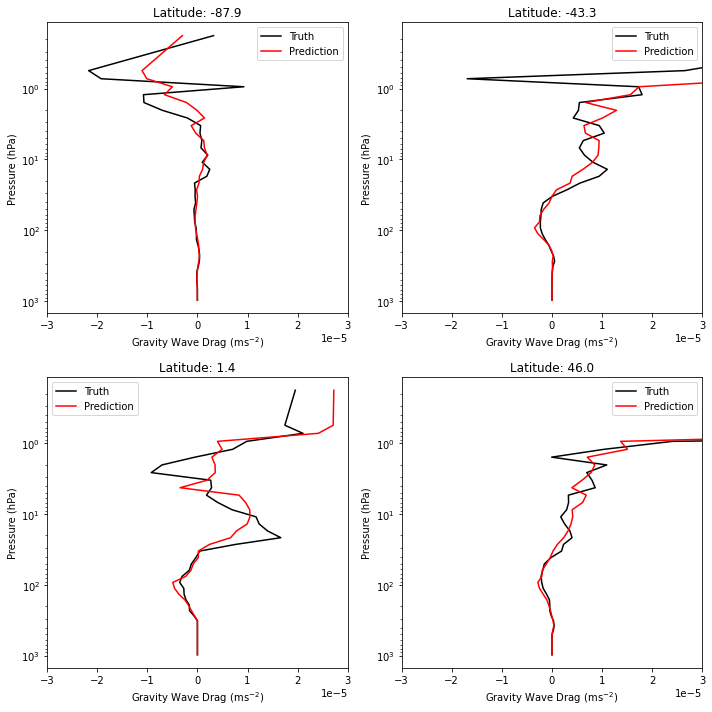

In [20]:
# Apply the inverse scaler:
Y_rescaled = gw_dataset.inverse_standard_scaler(Y.detach(), gwfu_mean, gwfu_sd)
Y_pred_rescaled = gw_dataset.inverse_standard_scaler(Y_pred.detach(), gwfu_mean, gwfu_sd)

fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()
# Plot a few samples for different latitudes
for i, j in enumerate(range(0, 64, 16)):
    plt.sca(ax[i])
    plt.semilogy(Y_rescaled[j,:], 
                 gw_dataset.pfull, 
                 color="black", label="Truth")
    plt.semilogy(Y_pred_rescaled[j,:],
                 gw_dataset.pfull, 
                 color="red", label="Prediction")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.axis(xmin=-3e-5, xmax=3e-5)
    plt.title(f"Latitude: {gw_dataset.lat[j]:.1f}")
    plt.xlabel("Gravity Wave Drag (ms$^{-2}$)")
    plt.ylabel("Pressure (hPa)")
plt.tight_layout()

These profiles look much more realistic for gravity wave drag so they we can make more sense of them. Our predictions look okay for now, but will improve as they are trained for more epochs. 